In [2]:
from region_utils.shapes import Circle, ConvexPolygon
from region_utils.region import Domain, Subdomain
import jax.numpy as np
import numpy as onp
import json


#### Domain with matching dimensionality of problem in [DFG flow around cylinder benchmark 2D-1](https://wwwold.mathematik.tu-dortmund.de/~featflow/en/benchmarks/cfdbenchmarking/flow/dfg_benchmark1_re20.html) 

$$\omega =[0,2.2]×[0,0.41]∖B_r(0.2,0.2)$$
$$r = 0.05$$
Without subdomain decomposition (@JunmiaoHu)

In [3]:
#vertecies of domain in counter clockwise order
v1 = [0,0]
v2 = [2.2,0]
v3 = [2.2, 0.41]
v4 = [0, 0.41]

domain_points = np.asarray([v1, v2, v3, v4])
Cylinder = Circle(center=np.array([0.2, 0.2]), radius=0.05, has_boundary=True)
OuterRectangle = ConvexPolygon(domain_points, list(range(4)))

In [4]:
subdomain0 = Subdomain([OuterRectangle], [Cylinder])
domain = Domain([subdomain0])

In [5]:
domain.create_boundary(100)
domain.create_interior(500, [0, 0], [2.2, 0.41])

(498, 2)


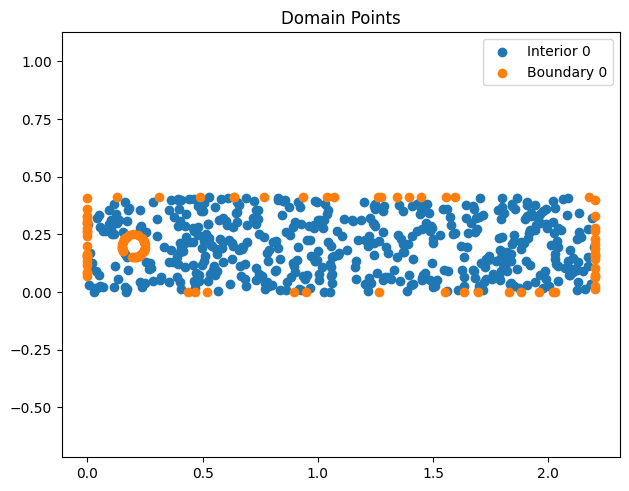

In [6]:
import matplotlib.pyplot as plt

plt.axis("equal")
# tight layout
plt.tight_layout()

domain.plot()

In [7]:
from utils import data_path

domain.write_to_file(data_path / "navier_stokes_pinn_train.json")

We need to add temporal dimention to data. As the code for generating 2d data is very
object oriented I suggest we do this manually with uglier ux

In [8]:
def add_temporal_dimension_training_data(input_file, t_max = 10, overwrite=False):
    str_rep = str(input_file)
    wo_suff = str_rep.removesuffix(".json")
    if overwrite:
        outfile = input_file
    else: 
        outfile = f"{wo_suff}_w_temporal.json"
    with open(input_file, "r") as infile:
        data = json.load(infile)
        for p in data['XPINNs']:
            for point in p['Internal points']:
                point.append(float(onp.random.uniform(0, t_max)))
            for point in p['Boundary points']:
                point.append(float(onp.random.uniform(0, t_max)))       
        for s in data['Interfaces']:
            for point in s['Points']:
                point.append(float(onp.random.uniform(0, t_max)))
                
    with open(outfile, "w") as outfile:
        json.dump(data, outfile)

Sanity check on XPINN_template

In [9]:
file = data_path / "XPINN_template.json"
add_temporal_dimension_training_data(file)

outfile = data_path / "XPINN_template_w_temporal.json"
with open(outfile, "r") as infile:
        data = json.load(infile)
        print(data)

{'XPINNs': [{'Internal points': [[0.5, 0.5, 3.4317265531630903], [0.7, 0.6, 5.18261977026998], [0.8, 0.9, 9.979865462270965]], 'Boundary points': [[0, 0, 0.026131685331693966], [1, 0, 1.7590668296009626], [0.5, 0, 9.491371979857293]]}, {'Internal points': [[0.5, 1.5, 7.041274023787185], [0.7, 1.6, 0.09479040465441457], [0.8, 1.9, 2.6144662017630282]], 'Boundary points': [[1, 2, 6.823546645928761], [1.5, 2, 6.992018075770368], [0.5, 2, 9.209875454983282]]}], 'Interfaces': [{'XPINNs': [0, 1], 'Points': [[1, 1, 5.602186106952569], [0.2, 1, 7.1186168304718], [1.5, 1, 5.149003922545714]]}]}


In [10]:
file = data_path / "navier_stokes_pinn_train.json"
add_temporal_dimension_training_data(file, overwrite=True)

Let's attempt to sort the different boundaries

In [11]:
def sort_boundaries(input_file, overwrite=False):
    str_rep = str(input_file)
    wo_suff = str_rep.removesuffix(".json")
    if overwrite:
        outfile = input_file
    else:
        outfile = f"{wo_suff}_sorted.json"
    with open(input_file, "r") as infile:
        data = json.load(infile)
        #create buckets for the different boundaries
        left_boundary  = []
        top_and_bottom_boundary = []
        cylinder_boundary = []
        right_boundary = []
        for p in data['XPINNs']:
            for point in p['Boundary points']:
                if point[0] == 0:
                    left_boundary.append(point)
                    
                if point[0] == 2.2:
                    right_boundary.append(point)
                    
                elif point[1] == 0.41 or point[1] == 0:
                    top_and_bottom_boundary.append(point)
                    
                else:
                    cylinder_boundary.append(point)
            #now we combine the buckets and note the indecies of the different boundaries
            all_boundaries = left_boundary + top_and_bottom_boundary + cylinder_boundary + right_boundary
            left_boundary_index = len(left_boundary)
            top_and_bottom_boundary_index = left_boundary_index + len(top_and_bottom_boundary)
            cylinder_boundary_index = top_and_bottom_boundary_index + len(cylinder_boundary)
            right_boundary_index = cylinder_boundary_index + len(right_boundary)
           
            p['Boundary points'] = all_boundaries
            p['left boundary'] = left_boundary
            p['top and bottom boundary'] = top_and_bottom_boundary
            p['cylinder boundary'] = cylinder_boundary
            p['right boundary'] = right_boundary
            p['Boundary indices'] = [left_boundary_index, top_and_bottom_boundary_index, cylinder_boundary_index, right_boundary_index]
            
            #p['Boundary indices'] = {}
            #p['Boundary indices']['left'] = left_boundary_index
            #p['Boundary indices']['top_and_bottom'] = top_and_bottom_boundary_index
            #p['Boundary indices']['cylinder'] = cylinder_boundary_index
            #p['Boundary indices']['right'] = right_boundary_index
    
    with open(outfile, "w") as outfile:
        json.dump(data, outfile)

In [12]:
file = data_path / "navier_stokes_pinn_train.json"
sort_boundaries(file, overwrite=True)

#### Test data

We would like to animate our solution so we generate random points in the xy plane, duplicate them and add a temporal dimention. (Not sure what resolution is sufficient)

In [22]:
domain.create_testing_data(20, v1, v3)
domain.write_to_file(data_path / "navier_stokes_test.json", False)

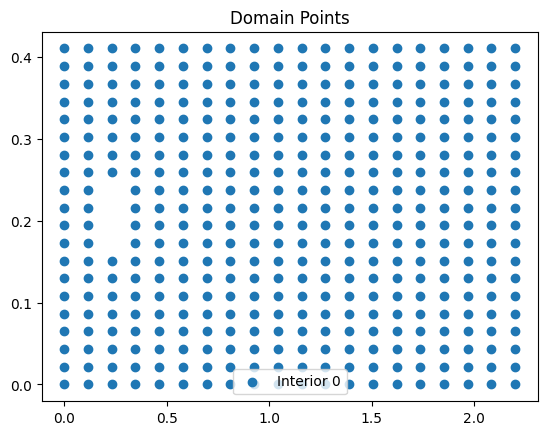

In [23]:
domain.plot(False)

In [24]:
def add_temporal_dimension_test_data(input_file, n:int = 2, t_max = 10, overwrite=False):
    """Adds temporal dimention to data

    Args:
        input_file (str): .json file with data w/o temporal dimension
        n (int, optional): temporal resolution. Defaults to 100.
        overwrite (bool, optional): overwrites infile if true. Defaults to False.
    """
    t = np.linspace(0, t_max, n)
    str_rep = str(input_file)
    wo_suff = str_rep.removesuffix(".json")
    if overwrite:
        outfile = input_file
    else:
        outfile = f"{wo_suff}_test_w_temporal.json"
    with open(input_file, "r") as infile:
        data = json.load(infile)
        for p in data['XPINNs']:
            m = len(p['Internal points'])
            k = len(p['Boundary points'])
            p['Internal points'] = n*p['Internal points']
            p['Boundary points'] = n*p['Boundary points']
            for i in range(n-1):
                for point in p['Internal points'][i*m:m*(i+1)]:
                    point.append(float(t[i]))
                for point in p['Boundary points'][i*k:k*(i+1)]:
                    point.append(float(t[i]))
    with open(outfile, "w") as outfile:
        json.dump(data, outfile)

Sanity check on template. This might be a goofy way of doing it idk.

In [25]:
file = data_path / "XPINN_template.json"
add_temporal_dimension_test_data(file, n=2, t_max=3)

outfile = data_path / "XPINN_template_test_w_temporal.json"
with open(outfile, "r") as infile:
       data = json.load(infile)
       print(data)

{'XPINNs': [{'Internal points': [[0.5, 0.5, 0.0], [0.7, 0.6, 0.0], [0.8, 0.9, 0.0], [0.5, 0.5, 0.0], [0.7, 0.6, 0.0], [0.8, 0.9, 0.0]], 'Boundary points': [[0, 0, 0.0], [1, 0, 0.0], [0.5, 0, 0.0], [0, 0, 0.0], [1, 0, 0.0], [0.5, 0, 0.0]]}, {'Internal points': [[0.5, 1.5, 0.0], [0.7, 1.6, 0.0], [0.8, 1.9, 0.0], [0.5, 1.5, 0.0], [0.7, 1.6, 0.0], [0.8, 1.9, 0.0]], 'Boundary points': [[1, 2, 0.0], [1.5, 2, 0.0], [0.5, 2, 0.0], [1, 2, 0.0], [1.5, 2, 0.0], [0.5, 2, 0.0]]}], 'Interfaces': [{'XPINNs': [0, 1], 'Points': [[1, 1], [0.2, 1], [1.5, 1]]}]}


In [26]:
add_temporal_dimension_test_data(data_path / "navier_stokes_test.json", n=10, t_max=3, overwrite=True)